In [7]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import glob

def readImagesAndExposureTimes():
    image_paths = glob.glob("..\\assets\\HDR\\hdr_image[1-4]*")
    image_paths.sort()
    
    """
    Exposure time, also known as shutter speed, is the duration for which a 
    camera's sensor (or film) is exposed to light when taking a photograph.
    Exposure time is typically measured in seconds or fractions of a second (e.g., 1/60, 1/1000).
    """
    exposureTimes = np.array([1/30, 0.25, 2.5, 15.0], dtype=np.float32) # This could be dynamically read from image metadata.
    images = []
    
    for image_path in image_paths:
        temp = cv.imread(image_path)[:,:,::-1]
        images.append(temp)
    
    return images, exposureTimes

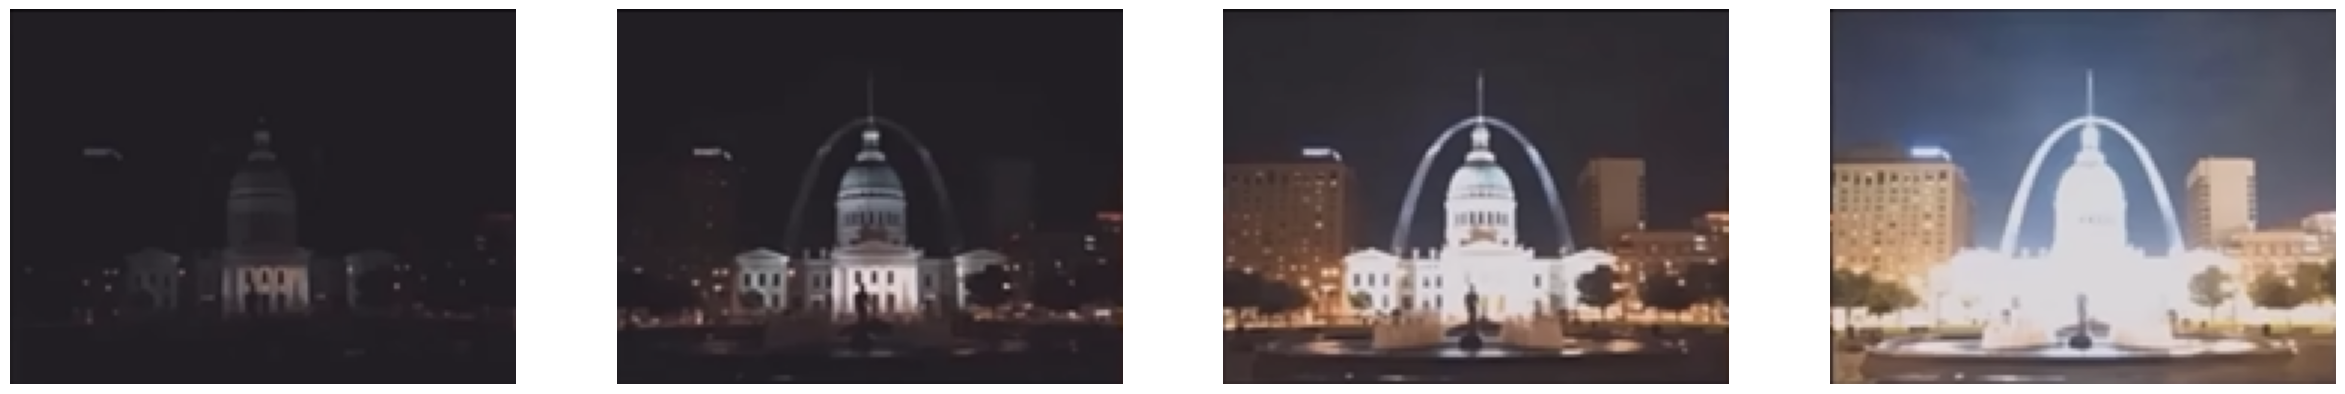

In [8]:
images, exposureTimes = readImagesAndExposureTimes()

plt.figure(figsize=[30,10])
for i, image in enumerate(images):
    plt.subplot(140 + i + 1)
    plt.imshow(image)
    plt.axis("off")


In [9]:
# The images must be aligned at subpixel level for a better result
"""
The AlignMTB class is used for image alignment, specifically designed 
to align images taken at different exposures. The method uses a Multi-
scale Template Matching technique to achieve precise subpixel-level 
alignment, which is crucial for HDR imaging.
"""
alignMTB = cv.createAlignMTB()
# pass a list of unaligned images and receive a list of aligned images
# (in this case we're overriding the old list)
alignMTB.process(images, images)

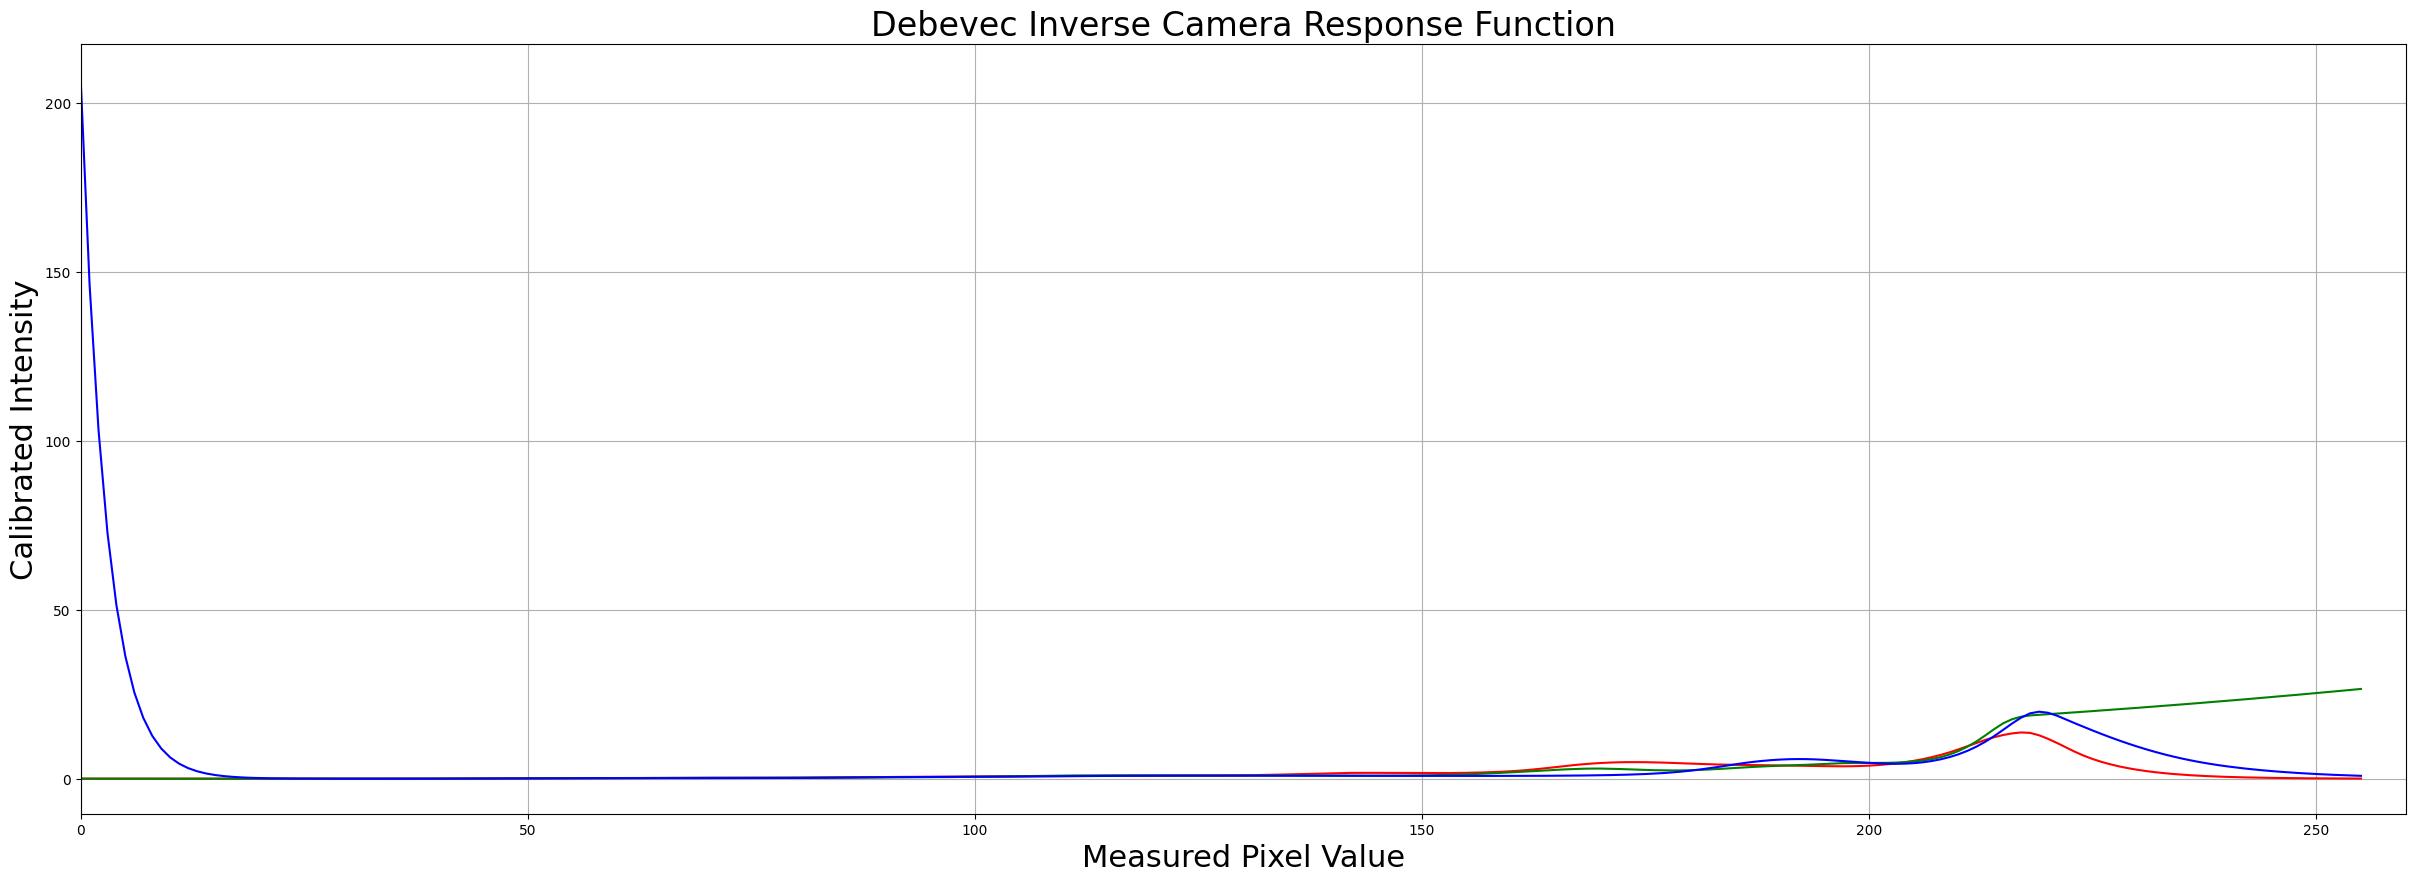

In [10]:
# ESTIMATING CAMERA RESPONSE FUNCTION
#
# We basically need to do all this just because the conversion between 
# light intensity and pixel intensity is not linear in some cases.
#
# For cameras which are NOT linear (most of them):
# If the radiance (light) in the photo doubles, the intensity of pixels 
# not necessarely doubles. This is a problem when we want to merge
# images taken at different exposure times.
#
# Find Camera Response Function (CRF):
# The Camera Response Function is a mathematical model that describes how 
# the camera sensor translates the actual light intensity (radiance) in a 
# scene into the pixel values that are recorded in an image.
# 
# To create a good HDR image, it's essential to estimate the CRF accurately. 
# This is typically done using a set of images taken at different exposure 
# levels and known exposure times. The goal is to find a function that best 
# maps the measured pixel values back to the actual light intensities.
calibrateDebevec = cv.createCalibrateDebevec()
# It's called inverse CRF because we're mapping pixel values back to the 
# corresponding light intensities (radiance) in the scene.
inverseCRF = calibrateDebevec.process(images, exposureTimes)

# SHOWING INVERSE CRF
x = np.arange(256, dtype=np.uint8)
# The np.squeeze function in NumPy is used to remove single-dimensional entries 
# from the shape of an array. This means it will eliminate dimensions that have 
# a size of 1, allowing for a more compact representation of the array.
y = np.squeeze(inverseCRF)

plt.figure(figsize=[30,10])
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0,260])
plt.grid()
arg1 = x, y[:, 0], "r"
arg2 = x, y[:, 1], "g"
arg3 = x, y[:, 2], "b"
plt.plot(*arg1, *arg2, *arg3)

# We can now linearize input images by mapping Measured Pixel Intensities (or Values) to the Calibrated Intensities


In [11]:
# We can now linearize input images by mapping Measured Pixel Intensities (or values) to the Calibrated Intensities
"""
Calibrated Intensities: When we talk about calibrated intensities, we mean the values obtained 
after applying the inverse CRF to the pixel values. This process linearizes the pixel values, 
mapping them to actual light intensities. These calibrated intensities accurately represent the 
amount of light that produced the original pixel values, allowing for better merging and processing 
in HDR imaging.
"""
mergeDebevec = cv.createMergeDebevec()
# The merging process intentionally ignores pixel values close to 0 or 255 because generally they don't
# have useful information.
# This is the HDR image, but its values vary from 0 to infinity, thus we use float32 or others data types to store them.
hdrDebevec = mergeDebevec.process(images, exposureTimes, inverseCRF)

True

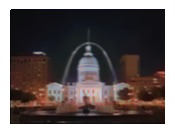

In [12]:
# TONEMMAPING
# Process of mapping HDR images (float32 or other type) to 8bits-per-channel (24bits total) images.

tonemap = cv.createTonemapDrago(gamma=1.0, saturation=0.7)

# After tonemapping, the values in ldrDrago are typically in the range of 0 to 1. 
# This is common for floating-point images, where 0 represents no intensity (black) 
# and 1 represents full intensity (white).
ldrDrago = tonemap.process(hdrDebevec)

# If the tonemapped image appears too dark, scaling by a factor of 3 can make the 
# image brighter, making details more visible (in this case it became too bright)
"""
After scaling the values, it's crucial to ensure that the resulting values 
remain within the valid range for an 8-bit image (0 to 255). If the values 
exceed 1.0 after the scaling, you should clip them to avoid overflow or 
convert them to the appropriate format (e.g., by normalizing to the range 
0-255) before saving or displaying the image.
"""
# ldrDrago = 3 * ldrDrago

plt.figure(figsize=[2,5]); 
plt.imshow(
    np.clip(ldrDrago, 0, 1)
)
plt.axis("off")

# The multiplication by 255 is done to convert the tonemapped image from a floating-point
# representation back to an 8-bit integer format suitable for saving as an image (it still
# remais as float to be truncated).
# 
# OBS:
# cv.imwrite CAN accept floating-point arrays as input. When you provide a floating-point 
# array (even after scaling), OpenCV will automatically convert these values to 8-bit 
# integers (0-255) for saving.
cv.imwrite("drago.jpg", (ldrDrago * 255)[:,:,::-1]) # back to BGR before writing